### **Performing XAI on image dataset**

In [ ]:
!pip3 install quantus

In [ ]:
!pip3 install captum

### Import Libraries and prepare the dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import quantus
from quantus import AVAILABLE_XAI_METHODS_CAPTUM
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients, GradientShap, Saliency, InputXGradient
from captum.attr import visualization as viz

# 1. Dataset Preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Available XAI Methods in Quantus: ['GradientShap', 'IntegratedGradients', 'DeepLift', 'DeepLiftShap', 'InputXGradient', 'Saliency', 'FeatureAblation', 'Deconvolution', 'FeaturePermutation', 'Lime', 'KernelShap', 'LRP', 'Gradient', 'Occlusion', 'LayerGradCam', 'GuidedGradCam', 'LayerConductance', 'LayerActivation', 'InternalInfluence', 'LayerGradientXActivation', 'Control Var. Sobel Filter', 'Control Var. Constant', 'Control Var. Random Uniform']


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


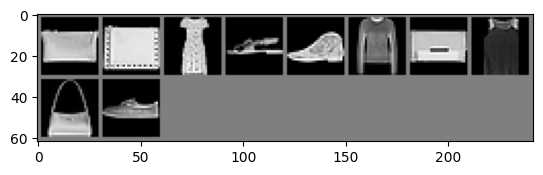

In [16]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:10]))

### Prepare the model

In [14]:
# 2. Define the LeNet Model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet()

### Train the model

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}")

train_model(model, train_loader, criterion, optimizer)

Epoch 1/10, Loss: 0.6467001081497938
Epoch 2/10, Loss: 0.41757802334802746
Epoch 3/10, Loss: 0.3582102958518051
Epoch 4/10, Loss: 0.32322249664013575
Epoch 5/10, Loss: 0.30199775619229785
Epoch 6/10, Loss: 0.28341284270352646
Epoch 7/10, Loss: 0.26701586069995914
Epoch 8/10, Loss: 0.2544295457976141
Epoch 9/10, Loss: 0.24194623093837614
Epoch 10/10, Loss: 0.23216585480550458


In [ ]:
# Confirm the availability of the methods in Quantus
print("Available XAI Methods in Quantus:", AVAILABLE_XAI_METHODS_CAPTUM)

In [10]:
import numpy as np

def generate_heatmaps(model, test_loader, methods):
    model.eval()
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        image = images[0:1]  # Select a single image for explanation
        label = labels[0].item()

        explanations = {}
        for name, method in methods.items():
            explanations[name] = method.attribute(image, target=label)
        
        print(explanations)

        # Visualize heatmaps
        fig, axs = plt.subplots(1, len(methods), figsize=(15, 5))
        axs = np.atleast_1d(axs)  # Ensure axs is always an array
        for j, (name, explanation) in enumerate(explanations.items()):
            viz.visualize_image_attr(
                explanation.cpu().detach().numpy()[0],
                image.cpu().numpy()[0][0],
                method="heat_map",
                plt_fig_axis=(fig, axs[j]),
                sign="all",
                show_colorbar=True,
                title=name,
            )

        plt.suptitle(f"Heatmaps for Image Label: {label}")
        plt.show()

        if i == 0:  # Only visualize for the first batch
            break


{<class 'captum.attr._core.integrated_gradients.IntegratedGradients'>: tensor([[[[-1.8576e-02, -2.0901e-02, -5.1787e-02, -3.1340e-02, -1.2339e-02,
            9.3814e-03, -2.3739e-02, -6.2723e-02, -6.8395e-02, -9.6537e-02,
           -5.5085e-02, -2.8560e-02,  1.3800e-01,  1.5835e-01,  2.6921e-01,
            1.8047e-01,  1.4461e-01,  4.8806e-02, -2.6802e-02, -6.7755e-02,
           -7.8137e-02, -4.3493e-03, -1.2675e-02,  1.6690e-03, -6.2436e-03,
           -1.0733e-02, -8.8753e-03, -9.9582e-04],
          [-2.0020e-02, -3.3877e-02, -7.7427e-02, -4.7818e-02,  1.3206e-04,
            3.7765e-02, -4.2025e-02, -5.9053e-02, -1.4000e-01, -1.2782e-01,
           -4.9385e-02, -3.4928e-03,  1.0247e-01,  1.5433e-01,  2.0728e-01,
            1.1236e-01,  3.5802e-02,  1.2996e-02, -8.8759e-02, -9.3469e-02,
           -1.4576e-02,  5.1947e-02, -1.4051e-02, -1.7583e-02, -1.8518e-02,
           -3.4117e-02, -6.6094e-03, -5.2259e-04],
          [-1.3186e-02, -3.5586e-02, -6.4034e-02, -2.9622e-02,  1.9

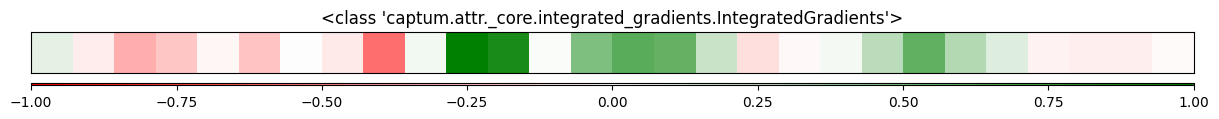

<Figure size 640x480 with 0 Axes>

In [11]:
generate_heatmaps(model, test_loader, methods={IntegratedGradients: IntegratedGradients(model)})

In [ ]:
methods = {
    "Integrated Gradients": IntegratedGradients(model),
    "Saliency": Saliency(model),
    "Input x Gradient": InputXGradient(model),
    # "GradientShap": GradientShap(model),
}

generate_heatmaps(model, test_loader, methods)